<a href="https://www.kaggle.com/code/sebastianandrade/logistic-regression-from-scratch?scriptVersionId=101179263" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Logistic Regression from scratch
In this notebook i solved a binary classification problem: "Titanic - Machine Learning from Disaster" from Kaggle. To solve the problem i used a Stochastic Gradient Descent implementation of Logistic Regression, and uses the Sigmoid probablity outcome to classify an input by applying a threshold to its probablity of belonging to the positive class.

In [1]:
import numpy as np 
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Logistic Regression implementation
Using stochastic gradient descent

In [2]:
class LogisticRegressor:
    def __init__(self, threshold, lr=0.001):
        self.lr = lr # Learning rate
        self.threshold = threshold # Classification threshold
        self._epoch_loss = np.empty(shape=(1,2)) # Array for stacking the loss by epoch
    
    @staticmethod
    def _log_loss(y, y_pred):
        return -1 * np.mean(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))
    
    @staticmethod
    def _sigmoid(z):
        '''Sigmoid function'''
        return 1 / (1 + np.exp(-z))
    
    @staticmethod
    def _z(X, w, b):
        '''Linear function to give to sigmoid as param'''
        return X.dot(w) + b
    
    @staticmethod
    def _sigmoid_dz(z):
        '''Derivative of sigmoid in respect to z'''
        return ( (np.exp(-z)) / (1 + np.exp(-z))**2 )
    
    @staticmethod
    def _loss_dy(y, y_pred):
        '''Derivative of log loss in respect to model predictions i.e sigmoid(z)'''
        return (-y/y_pred) + ( (1-y)/(1-y_pred) )
    
    def _plot_loss(self):
        plt.plot(
            self._epoch_loss[1:,0],
            self._epoch_loss[1:,1]
        )
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()
    
    def fit(self, X, y):
        self.w = np.ones(X.shape[1]) # Init weights
        self.b = 0 # Init Bias
        
        # Stochasitc gradient descent
        for epoch in range(100): # Epochs
            
            # Storing a history of epoch_n - loss pairs for plotting pourposes
            z_epoch = self._z(X, self.w, self.b)
            y_pred_epoch = self._sigmoid(z_epoch)
            epoch_loss = self._log_loss(y, y_pred_epoch)
            self._epoch_loss = np.vstack(
                (self._epoch_loss, 
                np.array([epoch, epoch_loss]))
            )
                
            for i in range(X.shape[0]): # Examples
                z = self._z(X[i], self.w, self.b)
                y_pred = self._sigmoid(z)
                dc_dz = self._loss_dy(y[i], y_pred) * self._sigmoid_dz(z)
                
                # Updating weights with cost derivative in respect to a given weight
                self.w = self.w - (self.lr * (dc_dz*X[i]) )
                self.b = self.b - (self.lr * dc_dz)
        self._plot_loss()
                                
    def predict(self, x):
        '''Predict probablities'''
        return self._sigmoid(self._z(x, self.w, self.b))
    
    def classify(self, x):
        '''Classify in function of probabilities'''
        prob = self.predict(x)
        # Positive class if prob >= threshold, else negative class
        return np.array(list(map(lambda a: 1 if a >= self.threshold else 0, prob)))

# Data preparation
Turning raw data into useful features

In [3]:
columns_to_exclude = ['Name','Ticket', 'Fare', 'Embarked', 'PassengerId', 'Cabin']
df = pd.read_csv('/kaggle/input/titanic/train.csv')

# Dropping columns with no predicting power
df.drop(labels=columns_to_exclude, inplace=True, axis=1)

# Filling NaN values with colomn mean for age column.
df.fillna(value=df['Age'].mean(), inplace=True)

# Using Z-score normalization for Age feature so as to have a same range as the other features
df['Age'] = (df['Age'] - df['Age'].mean()) / df['Age'].std()

# One hot encoding for Sex feature
sex_one_hot = pd.get_dummies(df['Sex'], prefix='is')
df = df.join(sex_one_hot)
df.drop(labels='Sex', axis=1, inplace=True)

# One hot encoding for Pclass feature
# If we let the model learn a proper weight of belonging to every passanger class in dataset
# this feature will have a more predictive power
pclass_one_hot = pd.get_dummies(df['Pclass'], prefix='is_from_class')
df = df.join(pclass_one_hot)
df.drop(labels='Pclass', axis=1, inplace=True)

df.head()

,Survived,Age,SibSp,Parch,is_female,is_male,is_from_class_1,is_from_class_2,is_from_class_3
0,0,-0.592148,1,0,0,1,0,0,1
1,1,0.638430,1,0,1,0,1,0,0
2,1,-0.284503,0,0,1,0,0,0,1
3,1,0.407697,1,0,1,0,1,0,0
4,0,0.407697,0,0,0,1,0,0,1


# Splitting data into test and validation sets

In [4]:
X = df.drop(labels='Survived', axis=1, inplace=False) # Features
y = df['Survived'].copy() # Label

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

# Training model

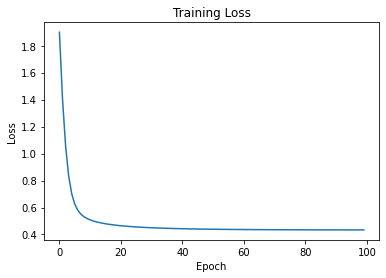

In [5]:
model = LogisticRegressor(threshold=0.5)
model.fit(X_train.values, y_train.values)

# Training model and computing metrics

Accuracy: 0.8044692737430168
Precision: 0.796875
Recall: 0.6986301369863014


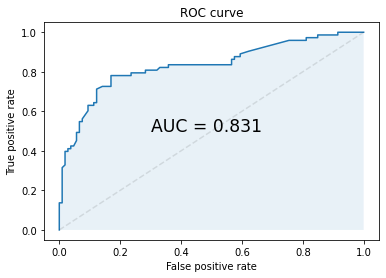

,True,Pred
0,1,1
1,0,0
2,1,1
3,0,1
4,1,1
5,0,0
6,0,0
7,1,1
8,0,0
9,1,1


In [6]:
y_pred = model.classify(X_val.values)
y_probs = model.predict(X_val.values)

z = pd.DataFrame({
    'True': y_val.values,
    'Pred': y_pred
})

print("Accuracy:", metrics.accuracy_score(y_val.values, y_pred))
print("Precision:", metrics.precision_score(y_val.values, y_pred))
print("Recall:", metrics.recall_score(y_val.values, y_pred))

# Ploting ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_val.values, y_probs)
auc = metrics.roc_auc_score(y_val.values, y_probs)
plt.plot(fpr, tpr)
plt.fill_between(fpr, tpr, alpha=0.1)
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.plot([0, 1], [0,1], 'k--', alpha=0.1)
plt.text(0.3, 0.5, f'AUC = {round(auc, 3)}', fontsize='xx-large')
plt.show()

z.head(10)

## The final submission of this model to Kaggle competition scored 0.75837 (The higher score possible is 1.0)

https://www.kaggle.com/code/sebastianandrade/titanic-challenge?scriptVersionId=100276781